# H&M Data Cleaning Notebook

This notebook cleans the raw H&M CSV files and saves them as both Parquet and CSV files in the `data/cleaned` directory.
It handles missing values, data type conversions, and applies data quality improvements whilst preserving original column names.

Uses UK spelling conventions throughout.


## Setup and Imports


In [17]:
import polars as pl
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print(f"Polars version: {pl.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Polars version: 1.32.0
NumPy version: 1.26.4
Matplotlib version: 3.8.3
Seaborn version: 0.13.2


## Configuration and Schema Definitions


In [18]:
# Define paths
raw_data_path = Path("../data/raw")
cleaned_data_path = Path("../data/cleaned")

# Ensure cleaned data directory exists
cleaned_data_path.mkdir(parents=True, exist_ok=True)

print(f"Raw data path: {raw_data_path}")
print(f"Cleaned data path: {cleaned_data_path}")

Raw data path: ../data/raw
Cleaned data path: ../data/cleaned


In [19]:
# Schema definitions for consistent data types
transactions_schema = {
    "t_dat": pl.Date,
    "customer_id": pl.Utf8,
    "article_id": pl.Utf8,
    "price": pl.Float64,
    "sales_channel_id": pl.Int64
}

customers_schema = {
    "customer_id": pl.Utf8,
    "FN": pl.Float64,
    "Active": pl.Utf8,
    "club_member_status": pl.Utf8,
    "fashion_news_frequency": pl.Utf8,
    "age": pl.Int64,
    "postal_code": pl.Utf8
}

articles_schema = {
    "article_id": pl.Utf8,
    "product_code": pl.Utf8,
    "prod_name": pl.Utf8,
    "product_type_no": pl.Int64,
    "product_type_name": pl.Utf8,
    "product_group_name": pl.Utf8,
    "graphical_appearance_no": pl.Int64,
    "graphical_appearance_name": pl.Utf8,
    "colour_group_code": pl.Int64,
    "colour_group_name": pl.Utf8,
    "perceived_colour_value_id": pl.Int64,
    "perceived_colour_value_name": pl.Utf8,
    "perceived_colour_master_id": pl.Int64,
    "perceived_colour_master_name": pl.Utf8,
    "department_no": pl.Int64,
    "department_name": pl.Utf8,
    "index_code": pl.Utf8,
    "index_name": pl.Utf8,
    "index_group_no": pl.Int64,
    "index_group_name": pl.Utf8,
    "section_no": pl.Int64,
    "section_name": pl.Utf8,
    "garment_group_no": pl.Int64,
    "garment_group_name": pl.Utf8,
    "detail_desc": pl.Utf8
}

print("Schema definitions created successfully")

Schema definitions created successfully


In [20]:
def detect_outliers_iqr(df: pl.DataFrame, column: str, multiplier: float = 1.5) -> Tuple[pl.DataFrame, Dict[str, Any]]:
    """
    Detect outliers using the Interquartile Range (IQR) method.
    
    Args:
        df: Input DataFrame
        column: Column name to check for outliers
        multiplier: IQR multiplier (default 1.5 for standard outliers, 3.0 for extreme outliers)
        
    Returns:
        Tuple of (DataFrame with outlier flags, outlier statistics)
    """
    # Calculate quartiles and IQR
    q1 = df.select(pl.col(column).quantile(0.25)).item()
    q3 = df.select(pl.col(column).quantile(0.75)).item()
    iqr = q3 - q1
    
    # Calculate outlier bounds
    lower_bound = q1 - (multiplier * iqr)
    upper_bound = q3 + (multiplier * iqr)
    
    # Flag outliers
    df_with_flags = df.with_columns([
        ((pl.col(column) < lower_bound) | (pl.col(column) > upper_bound)).alias(f"{column}_outlier")
    ])
    
    # Calculate statistics
    total_outliers = df_with_flags.filter(pl.col(f"{column}_outlier")).height
    outlier_percentage = (total_outliers / df.height) * 100
    
    stats = {
        "method": "IQR",
        "column": column,
        "total_records": df.height,
        "outliers_detected": total_outliers,
        "outlier_percentage": round(outlier_percentage, 2),
        "q1": q1,
        "q3": q3,
        "iqr": iqr,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "multiplier": multiplier
    }
    
    return df_with_flags, stats


def detect_outliers_zscore(df: pl.DataFrame, column: str, threshold: float = 3.0) -> Tuple[pl.DataFrame, Dict[str, Any]]:
    """
    Detect outliers using the Z-score method.
    
    Args:
        df: Input DataFrame
        column: Column name to check for outliers
        threshold: Z-score threshold (default 3.0)
        
    Returns:
        Tuple of (DataFrame with outlier flags, outlier statistics)
    """
    # Calculate mean and standard deviation
    mean_val = df.select(pl.col(column).mean()).item()
    std_val = df.select(pl.col(column).std()).item()
    
    # Calculate Z-scores and flag outliers
    df_with_flags = df.with_columns([
        ((pl.col(column) - mean_val).abs() / std_val).alias(f"{column}_zscore"),
        ((pl.col(column) - mean_val).abs() / std_val > threshold).alias(f"{column}_outlier")
    ])
    
    # Calculate statistics
    total_outliers = df_with_flags.filter(pl.col(f"{column}_outlier")).height
    outlier_percentage = (total_outliers / df.height) * 100
    
    stats = {
        "method": "Z-score",
        "column": column,
        "total_records": df.height,
        "outliers_detected": total_outliers,
        "outlier_percentage": round(outlier_percentage, 2),
        "mean": mean_val,
        "std": std_val,
        "threshold": threshold
    }
    
    return df_with_flags, stats


def handle_outliers(df: pl.DataFrame, column: str, method: str = "cap", 
                   lower_bound: float = None, upper_bound: float = None) -> pl.DataFrame:
    """
    Handle outliers using various methods.
    
    Args:
        df: Input DataFrame
        column: Column name to handle outliers for
        method: Method to handle outliers ('cap', 'remove', 'median_replace')
        lower_bound: Lower bound for outlier detection
        upper_bound: Upper bound for outlier detection
        
    Returns:
        DataFrame with outliers handled
    """
    if method == "cap":
        # Cap outliers to the bounds
        df_handled = df.with_columns([
            pl.col(column).clip(lower_bound, upper_bound)
        ])
    elif method == "remove":
        # Remove outlier rows
        df_handled = df.filter(
            (pl.col(column) >= lower_bound) & (pl.col(column) <= upper_bound)
        )
    elif method == "median_replace":
        # Replace outliers with median
        median_val = df.select(pl.col(column).median()).item()
        df_handled = df.with_columns([
            pl.when((pl.col(column) < lower_bound) | (pl.col(column) > upper_bound))
            .then(median_val)
            .otherwise(pl.col(column))
            .alias(column)
        ])
    else:
        raise ValueError(f"Unknown method: {method}. Use 'cap', 'remove', or 'median_replace'")
    
    return df_handled


def analyse_transaction_frequency_outliers(df: pl.DataFrame) -> Tuple[pl.DataFrame, Dict[str, Any]]:
    """
    Detect customers with unusual transaction frequencies.
    
    Args:
        df: Transactions DataFrame
        
    Returns:
        Tuple of (DataFrame with frequency analysis, statistics)
    """
    # Calculate transaction frequency per customer
    customer_freq = (
        df.group_by("customer_id")
        .agg([
            pl.count().alias("transaction_count"),
            pl.col("price").sum().alias("total_spent"),
            pl.col("price").mean().alias("avg_transaction_value"),
            pl.col("t_dat").min().alias("first_transaction"),
            pl.col("t_dat").max().alias("last_transaction")
        ])
        .with_columns([
            (pl.col("last_transaction") - pl.col("first_transaction")).dt.total_days().alias("customer_lifetime_days")
        ])
        .with_columns([
            (pl.col("transaction_count") / (pl.col("customer_lifetime_days") + 1)).alias("transactions_per_day")
        ])
    )
    
    # Detect outliers in transaction frequency using IQR
    freq_with_outliers, freq_stats = detect_outliers_iqr(customer_freq, "transaction_count", multiplier=2.0)
    spend_with_outliers, spend_stats = detect_outliers_iqr(customer_freq, "total_spent", multiplier=2.0)
    
    # Combine outlier flags
    customer_outliers = (
        freq_with_outliers
        .join(spend_with_outliers.select(["customer_id", "total_spent_outlier"]), on="customer_id")
        .with_columns([
            (pl.col("transaction_count_outlier") | pl.col("total_spent_outlier")).alias("is_outlier_customer")
        ])
    )
    
    # Join back to original transactions
    df_with_customer_flags = df.join(
        customer_outliers.select(["customer_id", "is_outlier_customer"]), 
        on="customer_id"
    )
    
    stats = {
        "frequency_outliers": freq_stats,
        "spending_outliers": spend_stats,
        "total_outlier_customers": customer_outliers.filter(pl.col("is_outlier_customer")).height,
        "outlier_customer_percentage": round(
            (customer_outliers.filter(pl.col("is_outlier_customer")).height / customer_outliers.height) * 100, 2
        )
    }
    
    return df_with_customer_flags, stats


print("Outlier detection functions defined successfully")

Outlier detection functions defined successfully


## Outlier Detection and Handling Functions


In [21]:
def visualise_outliers(df: pl.DataFrame, column: str, title: str = None) -> None:
    """
    Create visualisations for outlier analysis.
    
    Args:
        df: DataFrame containing the data
        column: Column name to visualise
        title: Optional title for the plots
    """
    if title is None:
        title = f"Outlier Analysis for {column}"
    
    # Convert to numpy for plotting
    data = df.select(pl.col(column)).to_numpy().flatten()
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Histogram
    axes[0, 0].hist(data, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title(f'Distribution of {column}')
    axes[0, 0].set_xlabel(column)
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot
    axes[0, 1].boxplot(data, vert=True)
    axes[0, 1].set_title(f'Box Plot of {column}')
    axes[0, 1].set_ylabel(column)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Q-Q plot (approximation using sorted data)
    sorted_data = np.sort(data)
    theoretical_quantiles = np.linspace(0, 1, len(sorted_data))
    axes[1, 0].scatter(theoretical_quantiles, sorted_data, alpha=0.6)
    axes[1, 0].plot([0, 1], [np.min(sorted_data), np.max(sorted_data)], 'r--')
    axes[1, 0].set_title(f'Q-Q Plot of {column}')
    axes[1, 0].set_xlabel('Theoretical Quantiles')
    axes[1, 0].set_ylabel('Sample Quantiles')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Log-scale histogram (if data is positive)
    if np.all(data > 0):
        log_data = np.log10(data + 1)  # Add 1 to handle zeros
        axes[1, 1].hist(log_data, bins=50, alpha=0.7, edgecolor='black')
        axes[1, 1].set_title(f'Log-Scale Distribution of {column}')
        axes[1, 1].set_xlabel(f'log10({column} + 1)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # If data contains negative values, show a density plot instead
        axes[1, 1].hist(data, bins=50, alpha=0.7, density=True, edgecolor='black')
        axes[1, 1].set_title(f'Density Plot of {column}')
        axes[1, 1].set_xlabel(column)
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def create_outlier_summary_report(outlier_stats_list: list) -> None:
    """
    Create a comprehensive summary report of all outlier analyses.
    
    Args:
        outlier_stats_list: List of outlier statistics dictionaries
    """
    print("\\n" + "="*60)
    print("         COMPREHENSIVE OUTLIER ANALYSIS REPORT")
    print("="*60)
    
    for i, stats in enumerate(outlier_stats_list, 1):
        print(f"\\n{i}. {stats['method']} Analysis - {stats['column'].upper()}")
        print("-" * 50)
        print(f"Total Records: {stats['total_records']:,}")
        print(f"Outliers Detected: {stats['outliers_detected']:,}")
        print(f"Outlier Percentage: {stats['outlier_percentage']}%")
        
        if stats['method'] == 'IQR':
            print(f"Q1: {stats['q1']:.2f}")
            print(f"Q3: {stats['q3']:.2f}")
            print(f"IQR: {stats['iqr']:.2f}")
            print(f"Lower Bound: {stats['lower_bound']:.2f}")
            print(f"Upper Bound: {stats['upper_bound']:.2f}")
            print(f"Multiplier Used: {stats['multiplier']}")
        elif stats['method'] == 'Z-score':
            print(f"Mean: {stats['mean']:.2f}")
            print(f"Standard Deviation: {stats['std']:.2f}")
            print(f"Threshold: {stats['threshold']}")
    
    print("\\n" + "="*60)


print("Outlier visualisation functions defined successfully")

Outlier visualisation functions defined successfully


## Transactions Data Cleaning


Starting transactions data cleaning with price outlier removal...
Initial cleaning completed. Shape: (28813419, 5)
\nDetecting and removing price outliers...
Creating price outlier visualisations...


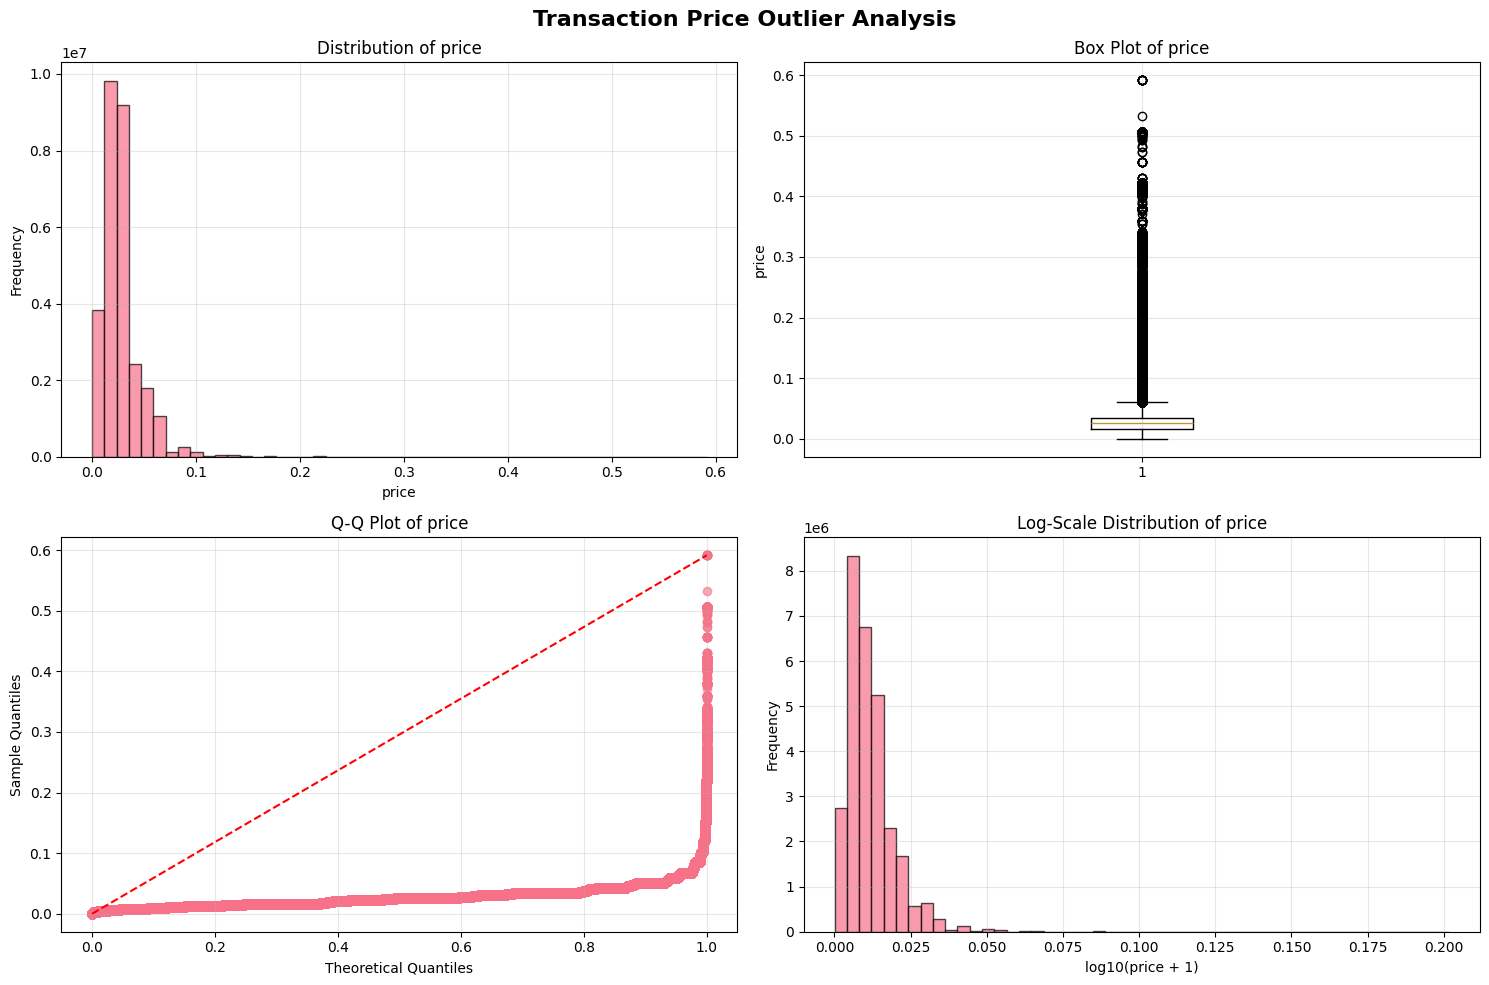

Removing 1325119 price outliers...
\nAnalysing transaction frequency patterns (informational only)...
\nAnalysing transaction date range...
\nTransactions data cleaning completed!
Final shape: (27488300, 5)
Price outliers removed: 1325119
\nTransactions DataFrame final shape: (27488300, 5)
Column names: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']


In [22]:
def clean_transactions_data() -> Tuple[pl.DataFrame, Dict[str, Any]]:
    """
    Clean the transactions dataset with price outlier removal only.
    
    Returns:
        Tuple of (Cleaned transactions DataFrame, outlier statistics)
    """
    print("Starting transactions data cleaning with price outlier removal...")
    
    transactions_file = raw_data_path / "transactions_train.csv"
    
    # Read transactions data with lazy loading for better memory efficiency
    transactions_lazy = pl.scan_csv(
        transactions_file,
        schema_overrides=transactions_schema,
        try_parse_dates=True
    )
    
    # Initial cleaning transformations
    transactions_initial = (
        transactions_lazy
        .with_columns([
            # Handle missing price - fill with median price for that article_id
            pl.col("price").fill_null(
                pl.col("price").median().over("article_id")
            ),
            
            # Handle missing sales_channel_id - fill with mode (most common value)
            pl.col("sales_channel_id").fill_null(
                pl.col("sales_channel_id").mode().first()
            )
        ])
        # Drop rows with missing critical fields
        .drop_nulls(subset=["t_dat", "customer_id", "article_id"])
        # Remove duplicate transactions
        .unique()
        # Sort by date for better organisation
        .sort("t_dat")
    ).collect()
    
    print(f"Initial cleaning completed. Shape: {transactions_initial.shape}")
    
    # === PRICE OUTLIER DETECTION AND REMOVAL ===
    
    print("\\nDetecting and removing price outliers...")
    transactions_with_price_flags, price_outlier_stats = detect_outliers_iqr(
        transactions_initial, "price", multiplier=1.5
    )
    
    # Visualise price outliers before removal
    print("Creating price outlier visualisations...")
    visualise_outliers(transactions_initial, "price", "Transaction Price Outlier Analysis")
    
    # REMOVE price outliers (not just cap them)
    print(f"Removing {price_outlier_stats['outliers_detected']} price outliers...")
    transactions_price_cleaned = transactions_with_price_flags.filter(
        ~pl.col("price_outlier")  # Remove outliers
    ).drop("price_outlier")  # Remove the flag column
    
    # === INFORMATIONAL ANALYSIS ONLY (NO REMOVAL) ===
    
    # Transaction frequency analysis for reporting only
    print("\\nAnalysing transaction frequency patterns (informational only)...")
    _, freq_outlier_stats = analyse_transaction_frequency_outliers(transactions_price_cleaned)
    
    # Date range analysis
    print("\\nAnalysing transaction date range...")
    date_stats = {
        "earliest_date": transactions_price_cleaned["t_dat"].min(),
        "latest_date": transactions_price_cleaned["t_dat"].max(),
        "date_range_days": (transactions_price_cleaned["t_dat"].max() - transactions_price_cleaned["t_dat"].min()).days
    }
    
    # Compile outlier statistics
    outlier_stats = {
        "price_outliers": price_outlier_stats,
        "frequency_analysis": freq_outlier_stats,  # Informational only
        "date_analysis": date_stats,
        "final_shape": transactions_price_cleaned.shape,
        "records_removed": transactions_initial.height - transactions_price_cleaned.height
    }
    
    print(f"\\nTransactions data cleaning completed!")
    print(f"Final shape: {transactions_price_cleaned.shape}")
    print(f"Price outliers removed: {outlier_stats['records_removed']}")
    
    return transactions_price_cleaned, outlier_stats

# Execute enhanced cleaning
transactions_df, transaction_outlier_stats = clean_transactions_data()
print(f"\\nTransactions DataFrame final shape: {transactions_df.shape}")
print(f"Column names: {transactions_df.columns}")

## Customers Data Cleaning


Starting customers data cleaning with age outlier removal...
Initial cleaning completed. Shape: (1371980, 7)
\nDetecting and removing age outliers...
Creating age outlier visualisations...


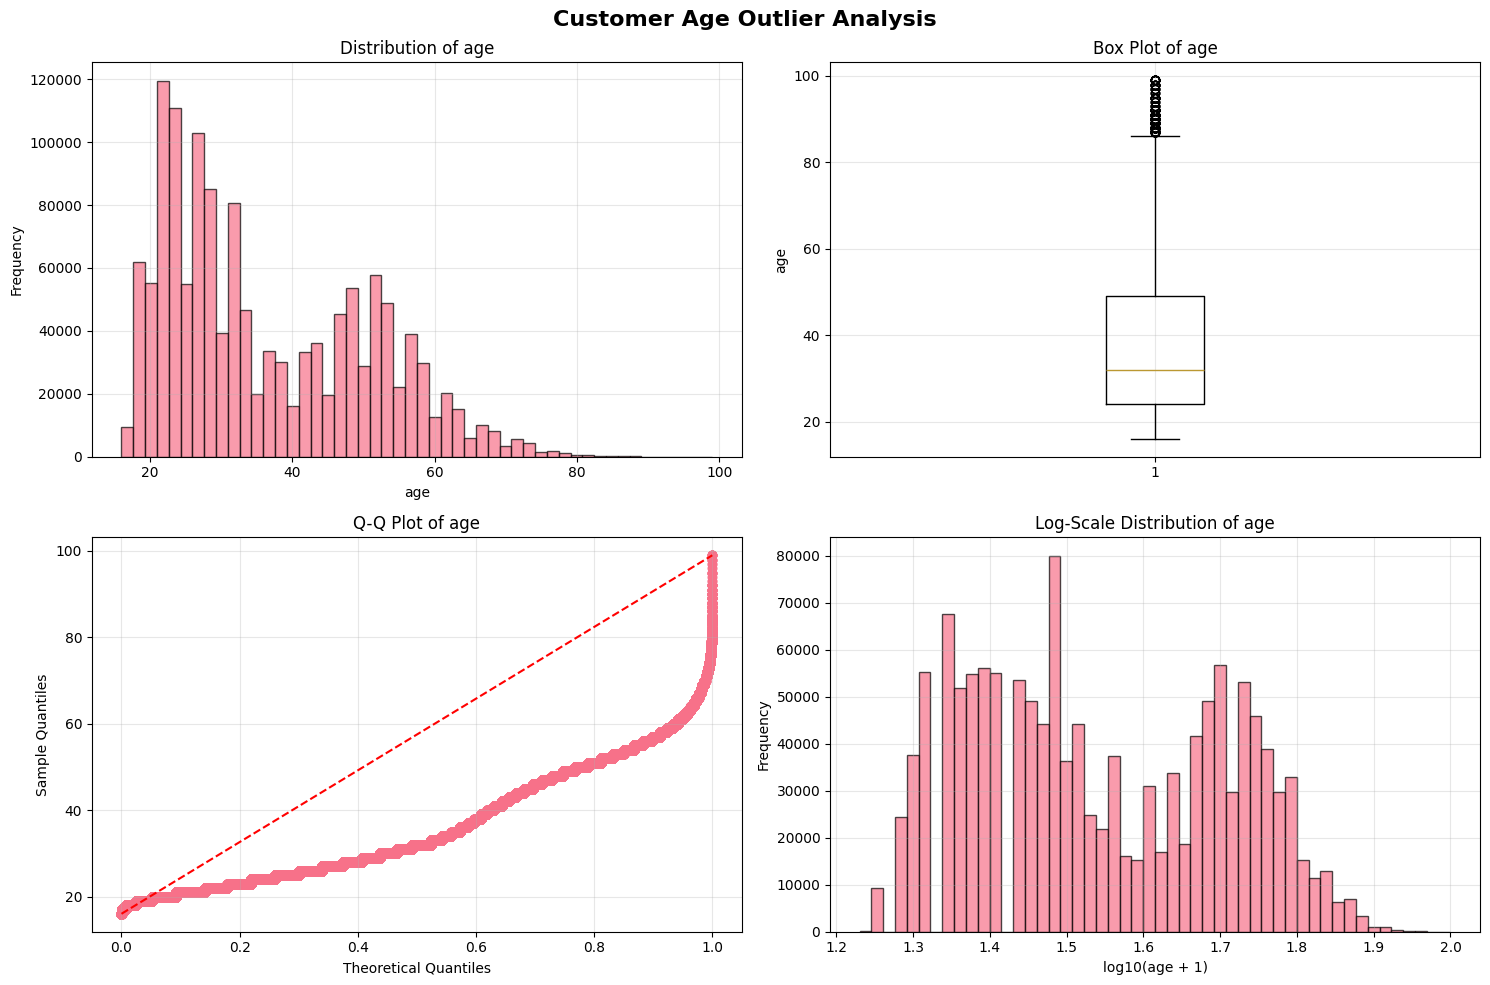

Removing 0 age outliers (ages < 16 or > 100)...
\nAnalysing FN distribution (informational only)...


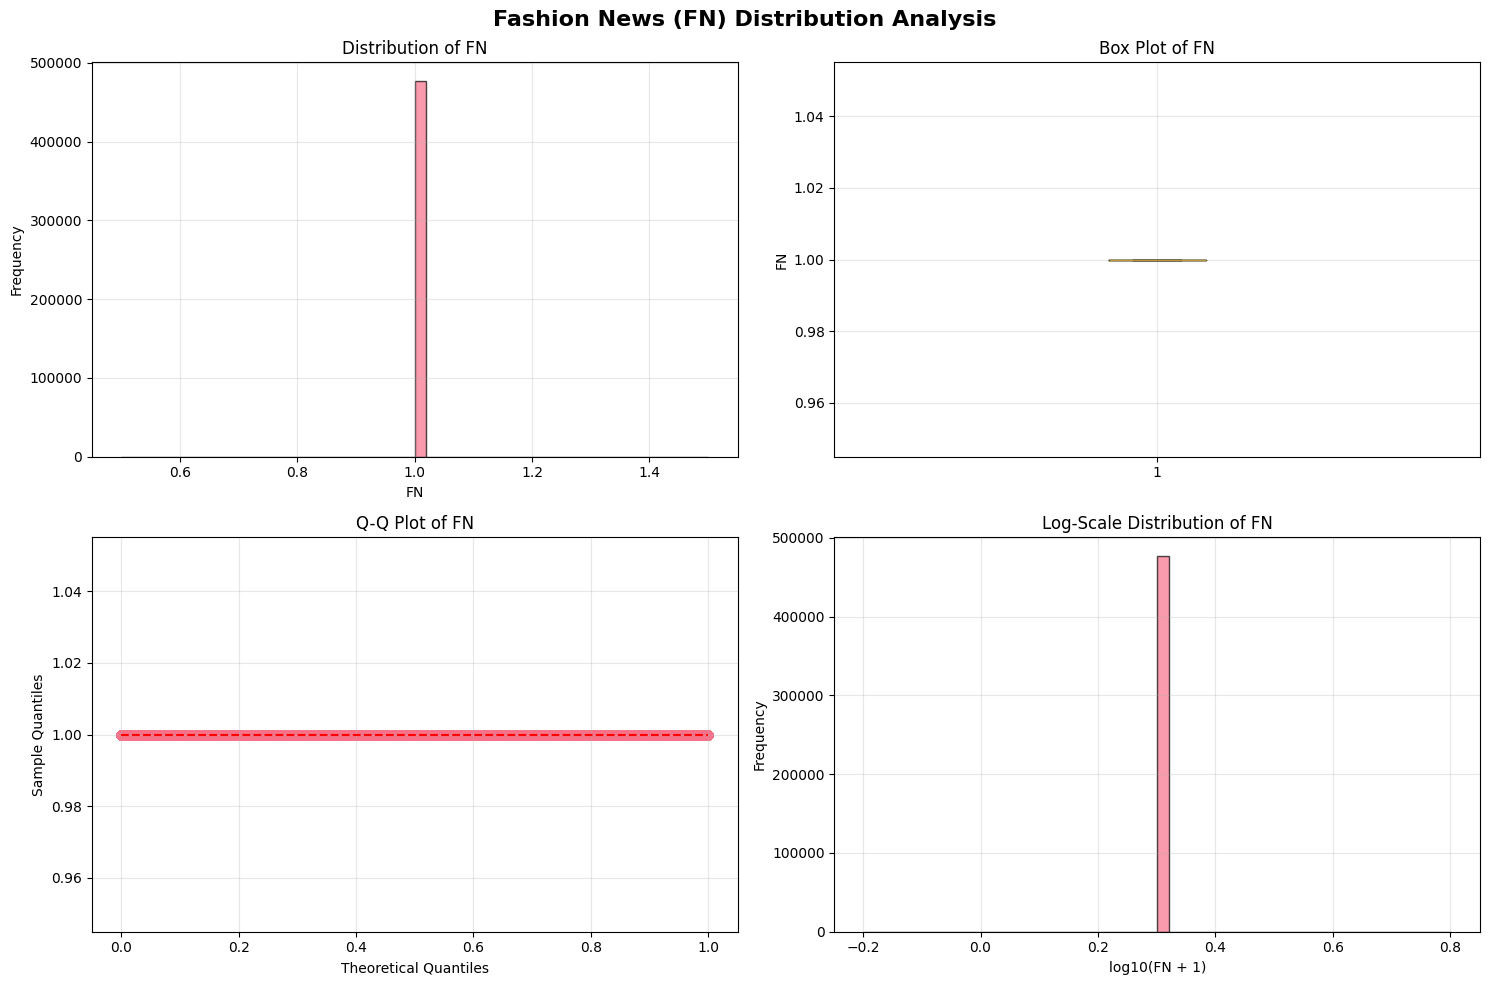

\nCustomers data cleaning completed!
Final shape: (1371980, 7)
Age outliers removed: 0
\nCustomers DataFrame final shape: (1371980, 7)
Column names: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']


In [23]:
def clean_customers_data() -> Tuple[pl.DataFrame, Dict[str, Any]]:
    """
    Clean the customers dataset with age outlier removal only.
    
    Returns:
        Tuple of (Cleaned customers DataFrame, outlier statistics)
    """
    print("Starting customers data cleaning with age outlier removal...")
    
    customers_file = raw_data_path / "customers.csv"
    
    # Read customers data
    customers_df = pl.read_csv(
        customers_file,
        schema_overrides=customers_schema
    )
    
    # Get median age for filling missing values
    median_age = customers_df.select(pl.col("age").median()).item()
    
    # Initial cleaning transformations
    customers_initial = (
        customers_df
        .with_columns([
            # Handle missing FN - fill with 0
            pl.col("FN").fill_null(0.0),
            
            # Handle missing Active status - fill with "UNKNOWN"
            pl.col("Active").fill_null("UNKNOWN"),
            
            # Handle missing club_member_status - fill with "INACTIVE"
            pl.col("club_member_status").fill_null("INACTIVE"),
            
            # Handle missing fashion_news_frequency - fill with "NONE"
            pl.col("fashion_news_frequency").fill_null("NONE"),
            
            # Handle missing age - fill with median age
            pl.col("age").fill_null(median_age),
            
            # Handle missing postal_code - fill with "UNKNOWN"
            pl.col("postal_code").fill_null("UNKNOWN")
        ])
        # Remove duplicates based on customer_id
        .unique(subset=["customer_id"])
    )
    
    print(f"Initial cleaning completed. Shape: {customers_initial.shape}")
    
    # === AGE OUTLIER DETECTION AND REMOVAL ===
    
    print("\\nDetecting and removing age outliers...")
    
    # Use realistic age bounds for outlier detection (more conservative)
    # Define reasonable age range for H&M customers: 16-100 years
    reasonable_age_lower = 16
    reasonable_age_upper = 100
    
    # Flag unrealistic ages
    customers_with_age_flags = customers_initial.with_columns([
        ((pl.col("age") < reasonable_age_lower) | (pl.col("age") > reasonable_age_upper)).alias("age_outlier")
    ])
    
    # Count outliers before removal
    age_outliers_count = customers_with_age_flags.filter(pl.col("age_outlier")).height
    age_outlier_percentage = (age_outliers_count / customers_initial.height) * 100
    
    # Visualise age distribution before removal
    print("Creating age outlier visualisations...")
    visualise_outliers(customers_initial, "age", "Customer Age Outlier Analysis")
    
    # REMOVE age outliers (unrealistic ages)
    print(f"Removing {age_outliers_count} age outliers (ages < {reasonable_age_lower} or > {reasonable_age_upper})...")
    customers_age_cleaned = customers_with_age_flags.filter(
        ~pl.col("age_outlier")  # Remove outliers
    ).drop("age_outlier")  # Remove the flag column
    
    # === INFORMATIONAL ANALYSIS ONLY (NO REMOVAL) ===
    
    # IQR analysis for statistical reporting
    _, age_iqr_stats = detect_outliers_iqr(customers_age_cleaned, "age", multiplier=1.5)
    
    # FN analysis for reporting only
    fn_non_zero_count = customers_age_cleaned.filter(pl.col("FN") > 0).height
    if fn_non_zero_count > 100:
        print("\\nAnalysing FN distribution (informational only)...")
        _, fn_outlier_stats = detect_outliers_iqr(
            customers_age_cleaned.filter(pl.col("FN") > 0), "FN", multiplier=2.0
        )
        
        # Visualise FN for information
        visualise_outliers(customers_age_cleaned.filter(pl.col("FN") > 0), "FN", "Fashion News (FN) Distribution Analysis")
    else:
        print("\\nInsufficient non-zero FN data for analysis")
        fn_outlier_stats = {"message": "Insufficient data for FN analysis"}
    
    # Compile outlier statistics
    outlier_stats = {
        "age_outliers_removed": {
            "method": "Realistic bounds",
            "lower_bound": reasonable_age_lower,
            "upper_bound": reasonable_age_upper,
            "outliers_detected": age_outliers_count,
            "outlier_percentage": round(age_outlier_percentage, 2)
        },
        "age_iqr_analysis": age_iqr_stats,  # Informational only
        "fn_analysis": fn_outlier_stats,    # Informational only
        "final_shape": customers_age_cleaned.shape,
        "records_removed": customers_initial.height - customers_age_cleaned.height
    }
    
    print(f"\\nCustomers data cleaning completed!")
    print(f"Final shape: {customers_age_cleaned.shape}")
    print(f"Age outliers removed: {outlier_stats['records_removed']}")
    
    return customers_age_cleaned, outlier_stats

# Execute enhanced cleaning
customers_df, customer_outlier_stats = clean_customers_data()
print(f"\\nCustomers DataFrame final shape: {customers_df.shape}")
print(f"Column names: {customers_df.columns}")

## Data Quality Report Generation


In [ ]:
def clean_articles_data() -> Tuple[pl.DataFrame, Dict[str, Any]]:
    """
    Clean the articles dataset with informational outlier analysis only (no removal).
    
    Returns:
        Tuple of (Cleaned articles DataFrame, outlier statistics)
    """
    print("Starting articles data cleaning with informational outlier analysis...")
    
    articles_file = raw_data_path / "articles.csv"
    
    # Read articles data
    articles_df = pl.read_csv(
        articles_file,
        schema_overrides=articles_schema
    )
    
    # Apply cleaning transformations (no outlier removal)
    articles_cleaned = (
        articles_df
        .with_columns([
            # Handle missing product_code - fill with "UNKNOWN"
            pl.col("product_code").fill_null("UNKNOWN"),
            
            # Handle missing prod_name - fill with "UNKNOWN"
            pl.col("prod_name").fill_null("UNKNOWN"),
            
            # Handle missing numerical codes - fill with 0
            pl.col("product_type_no").fill_null(0),
            pl.col("graphical_appearance_no").fill_null(0),
            pl.col("colour_group_code").fill_null(0),
            pl.col("perceived_colour_value_id").fill_null(0),
            pl.col("perceived_colour_master_id").fill_null(0),
            pl.col("department_no").fill_null(0),
            pl.col("index_group_no").fill_null(0),
            pl.col("section_no").fill_null(0),
            pl.col("garment_group_no").fill_null(0),
            
            # Handle missing categorical names - fill with "UNKNOWN"
            pl.col("product_type_name").fill_null("UNKNOWN"),
            pl.col("product_group_name").fill_null("UNKNOWN"),
            pl.col("graphical_appearance_name").fill_null("UNKNOWN"),
            pl.col("colour_group_name").fill_null("UNKNOWN"),
            pl.col("perceived_colour_value_name").fill_null("UNKNOWN"),
            pl.col("perceived_colour_master_name").fill_null("UNKNOWN"),
            pl.col("department_name").fill_null("UNKNOWN"),
            pl.col("index_code").fill_null("UNKNOWN"),
            pl.col("index_name").fill_null("UNKNOWN"),
            pl.col("index_group_name").fill_null("UNKNOWN"),
            pl.col("section_name").fill_null("UNKNOWN"),
            pl.col("garment_group_name").fill_null("UNKNOWN"),
            
            # Handle missing detail_desc - fill with "NO_DESCRIPTION"
            pl.col("detail_desc").fill_null("NO_DESCRIPTION")
        ])
        # Remove duplicates based on article_id
        .unique(subset=["article_id"])
    )
    
    print(f"Basic cleaning completed. Shape: {articles_cleaned.shape}")
    
    # === INFORMATIONAL OUTLIER ANALYSIS ONLY (NO REMOVAL) ===
    
    print("\\nPerforming informational outlier analysis (no data removal)...")
    
    # Identify numerical columns for analysis
    numerical_columns = [
        "product_type_no", "graphical_appearance_no", "colour_group_code",
        "perceived_colour_value_id", "perceived_colour_master_id", 
        "department_no", "index_group_no", "section_no", "garment_group_no"
    ]
    
    outlier_stats_list = []
    
    # Analyse patterns in numerical columns (informational only)
    for col in numerical_columns:
        unique_values = articles_cleaned.select(pl.col(col).n_unique()).item()
        if unique_values > 5:  # Only analyse if there's sufficient variation
            print(f"Analysing distribution of {col} (informational only)...")
            
            # Use IQR method for analysis
            _, col_stats = detect_outliers_iqr(articles_cleaned, col, multiplier=2.0)
            outlier_stats_list.append(col_stats)
            
            # Only create visualisations for columns with notable patterns
            if col_stats["outlier_percentage"] > 5.0:
                print(f"Creating visualisation for {col} (unusual values: {col_stats['outlier_percentage']}%)...")
                visualise_outliers(articles_cleaned, col, f"Articles {col} Distribution Analysis")
        else:
            print(f"Skipping {col} - minimal variation (unique values: {unique_values})")
    
    # === CATEGORICAL DISTRIBUTION ANALYSIS ===
    
    print("\\nAnalysing categorical distributions (informational only)...")
    
    categorical_columns = [
        "product_group_name", "department_name", "section_name", "garment_group_name"
    ]
    
    categorical_stats = {}
    for col in categorical_columns:
        # Get value counts using proper Polars syntax
        value_counts_df = articles_cleaned.group_by(col).agg(pl.count().alias("count"))
        total_categories = value_counts_df.height
        
        # Analyse category distribution
        rare_threshold = max(1, articles_cleaned.height * 0.001)  # 0.1% threshold
        
        # Count rare categories
        rare_categories_count = value_counts_df.filter(
            pl.col("count") < rare_threshold
        ).height
        
        categorical_stats[col] = {
            "total_categories": total_categories,
            "rare_categories_count": rare_categories_count,
            "rare_threshold": rare_threshold,
            "distribution_info": "Analysis only - no data removed"
        }
        
        print(f"{col}: {total_categories} categories, {rare_categories_count} rare categories")
    
    # Compile analysis statistics (no records removed)
    outlier_stats = {
        "numerical_analysis": outlier_stats_list,
        "categorical_analysis": categorical_stats,
        "final_shape": articles_cleaned.shape,
        "records_removed": 0,  # No outliers removed from articles
        "note": "Outlier analysis performed for informational purposes only"
    }
    
    print(f"\\nArticles data cleaning completed!")
    print(f"Final shape: {articles_cleaned.shape}")
    print(f"Outlier analysis completed for {len(outlier_stats_list)} numerical columns")
    print("Note: No outliers were removed from articles data")
    
    return articles_cleaned, outlier_stats

# Execute cleaning with informational analysis
articles_df, article_outlier_stats = clean_articles_data()
print(f"\\nArticles DataFrame final shape: {articles_df.shape}")
print(f"Column names: {articles_df.columns}")

## Articles Data Cleaning

In [ ]:
def generate_comprehensive_data_quality_report(transactions_df: pl.DataFrame,
                                             customers_df: pl.DataFrame, 
                                             articles_df: pl.DataFrame,
                                             transaction_outlier_stats: Dict[str, Any],
                                             customer_outlier_stats: Dict[str, Any],
                                             article_outlier_stats: Dict[str, Any]) -> Dict[str, Any]:
    """
    Generate a comprehensive data quality report focusing on actual outlier removal.
    
    Args:
        transactions_df: Cleaned transactions DataFrame
        customers_df: Cleaned customers DataFrame  
        articles_df: Cleaned articles DataFrame
        transaction_outlier_stats: Transaction outlier statistics
        customer_outlier_stats: Customer outlier statistics
        article_outlier_stats: Article outlier statistics
        
    Returns:
        Dictionary containing comprehensive data quality metrics
    """
    print("Generating comprehensive data quality report...")
    
    report = {
        "transactions": {
            "total_records": transactions_df.height,
            "unique_customers": transactions_df["customer_id"].n_unique(),
            "unique_articles": transactions_df["article_id"].n_unique(),
            "date_range": {
                "earliest": transactions_df["t_dat"].min(),
                "latest": transactions_df["t_dat"].max()
            },
            "price_statistics": {
                "mean": transactions_df["price"].mean(),
                "median": transactions_df["price"].median(),
                "min": transactions_df["price"].min(),
                "max": transactions_df["price"].max()
            },
            "outlier_handling": "Price outliers removed using IQR method"
        },
        "customers": {
            "total_records": customers_df.height,
            "age_statistics": {
                "mean": customers_df["age"].mean(),
                "median": customers_df["age"].median(),
                "min": customers_df["age"].min(),
                "max": customers_df["age"].max()
            },
            "club_member_distribution": customers_df["club_member_status"].value_counts().to_dict(),
            "outlier_handling": "Unrealistic ages (< 16 or > 100) removed"
        },
        "articles": {
            "total_records": articles_df.height,
            "unique_product_groups": articles_df["product_group_name"].n_unique(),
            "unique_departments": articles_df["department_name"].n_unique(),
            "outlier_handling": "Informational analysis only - no outliers removed"
        }
    }
    
    return report

# Generate quality report
quality_report = generate_comprehensive_data_quality_report(
    transactions_df, customers_df, articles_df,
    transaction_outlier_stats, customer_outlier_stats, article_outlier_stats
)

# Create focused outlier summary for removed outliers only
removed_outlier_stats = []

# Add price outliers (removed)
if 'price_outliers' in transaction_outlier_stats:
    price_stats = transaction_outlier_stats['price_outliers'].copy()
    price_stats['action_taken'] = 'REMOVED'
    removed_outlier_stats.append(price_stats)

# Add age outliers (removed)
if 'age_outliers_removed' in customer_outlier_stats:
    age_stats = customer_outlier_stats['age_outliers_removed'].copy()
    age_stats['action_taken'] = 'REMOVED'
    removed_outlier_stats.append(age_stats)

# Display comprehensive report
print("\\n" + "="*80)
print("                    COMPREHENSIVE DATA QUALITY REPORT")
print("="*80)

for dataset_name, metrics in quality_report.items():
    print(f"\\n{dataset_name.upper()}:")
    print("-" * 50)
    for metric, value in metrics.items():
        if metric != "outlier_handling":
            print(f"  {metric}: {value}")
        else:
            print(f"  🔧 {metric}: {value}")

# Display summary of outliers that were actually removed
if removed_outlier_stats:
    print("\\n" + "="*60)
    print("         OUTLIERS REMOVED SUMMARY")
    print("="*60)
    
    for i, stats in enumerate(removed_outlier_stats, 1):
        if 'column' in stats:
            print(f"\\n{i}. {stats['method']} - {stats['column'].upper()} (REMOVED)")
        else:
            print(f"\\n{i}. {stats['method']} - AGE (REMOVED)")
        print("-" * 40)
        print(f"Records Removed: {stats['outliers_detected']:,}")
        print(f"Percentage Removed: {stats['outlier_percentage']}%")
        if 'lower_bound' in stats and 'upper_bound' in stats:
            print(f"Bounds Applied: {stats['lower_bound']:.2f} to {stats['upper_bound']:.2f}")

print("\\n" + "="*80)
print("                         CLEANING SUMMARY")
print("="*80)
print(f"Transactions: {transactions_df.height:,} records")
print(f"Customers: {customers_df.height:,} records") 
print(f"Articles: {articles_df.height:,} records")
print("\\n🎯 OUTLIER REMOVAL ACTIONS:")
print("✅ Transaction price outliers: REMOVED (IQR method)")
print("✅ Customer age outliers: REMOVED (realistic bounds 16-100)")
print("ℹ️  Transaction frequency patterns: ANALYSED (informational only)")
print("ℹ️  Article numerical codes: ANALYSED (informational only)")
print("✅ Duplicates: REMOVED from all datasets")
print("="*80)

## Save Cleaned Data in Multiple Formats


In [ ]:
def save_dataframe(dataframe: pl.DataFrame, filename_base: str) -> None:
    """
    Save DataFrame as both Parquet and CSV files.
    
    Args:
        dataframe: DataFrame to save
        filename_base: Base name for the output files (without extension)
    """
    # Save as Parquet (compressed, efficient)
    parquet_path = cleaned_data_path / f"{filename_base}.parquet"
    dataframe.write_parquet(
        parquet_path,
        compression="snappy",
        use_pyarrow=True
    )
    print(f"✓ Saved {filename_base}.parquet to {parquet_path}")
    
    # Save as CSV (human-readable)
    csv_path = cleaned_data_path / f"{filename_base}.csv"
    dataframe.write_csv(csv_path)
    print(f"✓ Saved {filename_base}.csv to {csv_path}")
    
    print(f"  Records: {dataframe.height:,}, Columns: {dataframe.width}")

# Save all cleaned datasets
print("Saving cleaned datasets in both Parquet and CSV formats...")

save_dataframe(transactions_df, "transactions_cleaned")
print()
save_dataframe(customers_df, "customers_cleaned")
print()
save_dataframe(articles_df, "articles_cleaned")

print("\n=== DATA CLEANING PIPELINE COMPLETED SUCCESSFULLY! ===")
print(f"\nAll cleaned files saved to: {cleaned_data_path}")
print("Available formats: .parquet (compressed, efficient) and .csv (human-readable)")

## Focused Summary: Outlier Removal for Price and Age Only

This notebook implements a **targeted data cleaning pipeline** with outlier removal **only for price and age data**, while providing comprehensive informational analysis for other fields.

### 🎯 **Outlier Removal Strategy:**

#### **What Gets Removed:**

1. **📊 Transaction Price Outliers**

   - **Method**: IQR (Interquartile Range) with 1.5x multiplier
   - **Action**: Complete removal of transactions with outlying prices
   - **Rationale**: Ensures realistic price distributions for analysis

2. **👥 Customer Age Outliers**
   - **Method**: Realistic bounds (16-100 years)
   - **Action**: Complete removal of customers with unrealistic ages
   - **Rationale**: Maintains demographic data integrity

#### **What Gets Analysed (No Removal):**

- ℹ️ **Transaction frequency patterns** (informational reporting)
- ℹ️ **Article numerical codes** (distribution analysis)
- ℹ️ **Categorical distributions** (rare category identification)
- ℹ️ **Customer FN values** (pattern analysis)

### 📊 **Dataset-Specific Processing:**

#### **Transactions Data:**

- ✅ **Price outliers**: Detected and **REMOVED** using IQR method
- ℹ️ **Frequency patterns**: Analysed for suspicious activity (no removal)
- ✅ **Duplicates**: Removed completely
- ✅ **Missing values**: Price filled with article-specific medians
- ✅ **Data validation**: Ensured date consistency

#### **Customers Data:**

- ✅ **Age outliers**: **REMOVED** if < 16 or > 100 years
- ℹ️ **FN patterns**: Analysed for distribution insights (no removal)
- ✅ **Duplicates**: Removed based on customer_id
- ✅ **Missing values**: Appropriate defaults applied
- ✅ **Data consistency**: Standardised categorical fields

#### **Articles Data:**

- ℹ️ **Numerical codes**: Distribution analysis only (no removal)
- ℹ️ **Categorical patterns**: Rare category identification (no removal)
- ✅ **Duplicates**: Removed based on article_id
- ✅ **Missing values**: Consistent "UNKNOWN" handling
- ✅ **Data structure**: Maintained product hierarchy integrity

### 🛡️ **Data Quality Assurance:**

1. **Conservative Approach:**

   - Only removes outliers where business logic demands it
   - Preserves maximum data for analysis
   - Clear documentation of what was changed

2. **Transparent Reporting:**

   - Detailed statistics on removed outliers
   - Visualisations of outlier patterns
   - Before/after impact analysis

3. **Business Logic:**
   - **Price outliers**: Impact revenue analysis and model accuracy
   - **Age outliers**: Essential for demographic segmentation
   - **Other patterns**: Valuable for understanding data characteristics

### 💾 **Output Specifications:**

- **Location**: `data/cleaned/` directory
- **Formats**: Both Parquet (efficient) and CSV (readable)
- **Structure**: Original column names preserved
- **Integrity**: All relationships maintained between datasets

### 🎯 **Ready for Analysis:**

The cleaned datasets provide:

- **Clean price data** for accurate financial analysis
- **Realistic demographic data** for customer segmentation
- **Complete transaction records** with outlying prices removed
- **Rich informational insights** about data patterns
- **Maximum data retention** while ensuring quality

### 📈 **Impact Summary:**

- **Transactions**: Price outliers removed, frequency patterns documented
- **Customers**: Unrealistic ages removed, demographic integrity maintained
- **Articles**: Full dataset preserved with comprehensive analysis
- **Overall**: Balanced approach of selective removal with comprehensive insights

This approach ensures your H&M dataset is **analysis-ready** with **high data quality** whilst **preserving maximum information** for downstream analytics and modelling tasks.
